<a href="https://colab.research.google.com/github/Kashish314/Sentiment-Analysis-of-Text/blob/main/SentimentAnalysis_of_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import** **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import pickle

nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('pos_tag')
nltk.download('punkt')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

**Import** **Dataset**

In [ ]:
#imported csv file
data=pd.read_csv("./Women Clothing E-Commerce Reviews.csv")
data.head()


FileNotFoundError: ignored

In [ ]:
data.info()

**Data Cleaning**

In [ ]:
#rename data-coloumn
data=data.rename(columns={'Review Text': 'Reviews'})

NameError: ignored

In [ ]:
#remove missing values
data=data.dropna()
data.reset_index(drop=True, inplace=True)
data.isna().sum()

In [ ]:
#droping extra columns
data=data.drop(["Clothing ID","Division Name","Department Name","Class Name","Title","Age",
                "Positive Feedback Count","Recommended IND","Unnamed: 0","Rating"],axis=1)
data.info()


**Data Pre-Processing**

In [ ]:
import ssl
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


In [ ]:
def preprocess_Reviews_data(data,name):
    # Proprocessing the data
    data[name]=data[name].str.lower()
    # Code to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Code to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
    # Code to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # Code to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    # Code to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
    # Remove the twitter handlers
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))

# Function to tokenize and remove the stopwords    
def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen
        
        filtered_sentence = [] 

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 
        
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        
        return filtered_sentence
    # Using "getting(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

In [ ]:
lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

NameError: ignored

In [ ]:
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [ ]:
# Using the preprocessing function to preprocess the hotel data
preprocess_Reviews_data(data,'Reviews')
# Using tokenizer and removing the stopwords
rem_stopwords_tokenize(data,'Reviews')
# Converting all the texts back to sentences
make_sentences(data,'Reviews')

# Using the Lemmatization function to lemmatize the hotel data
Lemmatization(data,'Reviews')
# Converting all the texts back to sentences
make_sentences(data,'Reviews')

In [ ]:
data.head()

,Reviews
0,high hope dress really wanted work meinitially...
1,love love love jumpsuit itfun flirty fabulous ...
2,shirt flattering due adjustable front tie perf...
3,love tracy reese dress one petiteam foot tall ...
4,aded basket hte last mintue see would look lik...


**Labelling Dataset**

In [ ]:
pos=neg=obj=count=0

postagging = []

for review in data['Reviews']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

data['pos_tags'] = postagging

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []
    
    #SentiWordNet is a lexical resource for opinion mining. SentiWordNet assigns to each synset of WordNet three sentiment scores: positivity, negativity, objectivity. 
    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in data['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
data['senti_score'] = senti_score
print(data['senti_score'])

print(data.head)

0       -1.875
1        2.375
2        1.125
3       -0.125
4        0.875
         ...  
19657    1.250
19658   -0.625
19659    0.500
19660    0.875
19661    0.500
Name: senti_score, Length: 19662, dtype: float64
<bound method NDFrame.head of                                                  Reviews  ... senti_score
0      high hope dress really wanted work meinitially...  ...      -1.875
1      love love love jumpsuit itfun flirty fabulous ...  ...       2.375
2      shirt flattering due adjustable front tie perf...  ...       1.125
3      love tracy reese dress one petiteam foot tall ...  ...      -0.125
4      aded basket hte last mintue see would look lik...  ...       0.875
...                                                  ...  ...         ...
19657  happy snag dress suchgreat price itvery easy s...  ...       1.250
19658  reminds maternity clothes soft stretchy shiny ...  ...      -0.625
19659  fit well top see never would worked mem gladwa...  ...       0.500
19660  bought dr

In [ ]:
data.tail()

,Reviews,pos_tags,senti_score,Rating
19657,happy snag dress suchgreat price itvery easy s...,"[(happy, JJ), (snag, NN), (dress, NN), (suchgr...",1.250,Positive
19658,reminds maternity clothes soft stretchy shiny ...,"[(reminds, NNS), (maternity, NN), (clothes, NN...",-0.625,Negative
19659,fit well top see never would worked mem gladwa...,"[(fit, RB), (well, RB), (top, JJ), (see, NN), ...",0.500,Positive
19660,bought dress forweddinghave summer itso cute u...,"[(bought, VBD), (dress, NN), (forweddinghave, ...",0.875,Positive
19661,dress inlovely platinum feminine fit perfectly...,"[(dress, NN), (inlovely, RB), (platinum, JJ), ...",0.500,Positive


In [ ]:
def convert_sentiment(sentiment):
    if sentiment=='Negative':
        return 0  
    else:
      return 1;
data.Rating = data.Rating.apply(convert_sentiment)

In [ ]:
data=data.drop(['pos_tags','senti_score'], axis = 1)
data.head()

,Reviews,Rating
0,high hope dress really wanted work meinitially...,0
1,love love love jumpsuit itfun flirty fabulous ...,1
2,shirt flattering due adjustable front tie perf...,1
3,love tracy reese dress one petiteam foot tall ...,0
4,aded basket hte last mintue see would look lik...,1


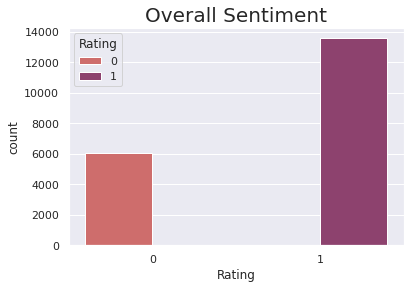

In [ ]:
#imbalance-dataset
sns.set(style="darkgrid")
bar = sns.countplot(x = 'Rating' , hue = 'Rating' , data = data, palette="flare")
bar.set_title("Overall Sentiment", size = 20)
plt.show()

**EDA**

In [ ]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in data['Reviews']])
# len(all_words.split())

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

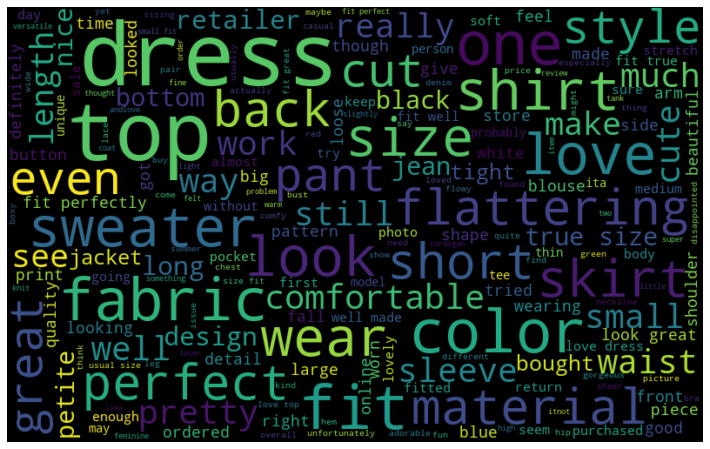

In [ ]:
# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Balancing Dataset** 

In [ ]:
X=data["Reviews"]
Y=data["Rating"]

In [ ]:
#feature-vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
  
X=tf.fit_transform(X)
X.shape

(19662, 290478)

In [ ]:
pkl_filename = "tf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tf, file)

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

smk = SMOTETomek(random_state=42 , sampling_strategy = 0.8)
X_res,y_res= smk.fit_sample(X,Y)

unique_elements, counts_elements = np.unique(y_res, return_counts=True)
np.asarray((unique_elements, counts_elements))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



array([[    0,     1],
       [10872, 13591]])

**Applying Maching Learning Models**

In [ ]:
#Featurization
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1 = train_test_split(X_res,y_res,test_size = 0.2 , random_state = 0) 

In [ ]:
# Classification Report
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
group_names = ['True Neg','False Pos','False Neg','True Pos']

In [ ]:
from sklearn.metrics import mean_squared_error, precision_score, recall_score,f1_score
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0

Logistic Regression

In [ ]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
logistic.fit(x_train1,y_train1)
#Generate predictions with the model using our X values
y_pred_lr = logistic.predict(x_test1)

In [ ]:
#classification_report
lr_report1=classification_report(y_test1,y_pred_lr,target_names=['0','1'])
print(lr_report1)
y_pred = logistic.predict(x_train1)

              precision    recall  f1-score   support

           0       1.00      0.36      0.53      2223
           1       0.65      1.00      0.79      2670

    accuracy                           0.71      4893
   macro avg       0.83      0.68      0.66      4893
weighted avg       0.81      0.71      0.67      4893



In [ ]:
  alg=LogisticRegression()
  MLA_name = alg.__class__.__name__
  MLA_compare.loc[row_index,'MLA Model'] = MLA_name
  MLA_compare.loc[row_index, 'Accuracy'] = round(logistic.score(x_test1, y_test1), 4)
  MLA_compare.loc[row_index, 'Precission'] = precision_score(y_test1, y_pred_lr)
  MLA_compare.loc[row_index, 'F1 Score']= f1_score(y_test1, y_pred_lr)

  row_index+=1
  MLA_compare

,MLA Model,Accuracy,Precission,F1 Score
0,LogisticRegression,0.7104,0.653291,0.790292


[[ 806 1417]
 [   0 2670]]


<function matplotlib.pyplot.show>

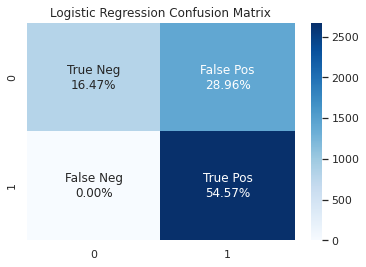

In [ ]:
#confusion matrix
cf_matrix = confusion_matrix(y_test1, y_pred_lr)
print(cf_matrix)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Naive Bayes Classifier - MultinomialNB



In [ ]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb_model=mnb.fit(x_train1,y_train1)

In [ ]:
mnb_bow_predict=mnb_model.predict(x_test1)

In [ ]:
mnb_bow_report = classification_report(y_test1,mnb_bow_predict)
print(mnb_bow_report)

              precision    recall  f1-score   support

           0       0.85      0.57      0.68      2223
           1       0.72      0.91      0.81      2670

    accuracy                           0.76      4893
   macro avg       0.78      0.74      0.74      4893
weighted avg       0.78      0.76      0.75      4893



In [ ]:
  alg=MultinomialNB()
  MLA_name = alg.__class__.__name__
  MLA_compare.loc[row_index,'MLA Model'] = MLA_name
  MLA_compare.loc[row_index, 'Accuracy'] = round(mnb_model.score(x_test1, y_test1), 4)
  MLA_compare.loc[row_index, 'Precission'] = precision_score(y_test1, mnb_bow_predict)
  MLA_compare.loc[row_index, 'F1 Score']=f1_score(y_test1,mnb_bow_predict)
  row_index+=1
  MLA_compare

,MLA Model,Accuracy,Precission,F1 Score
0,LogisticRegression,0.7104,0.653291,0.790292
1,MultinomialNB,0.7584,0.719210,0.805079


[[1270  953]
 [ 229 2441]]


<function matplotlib.pyplot.show>

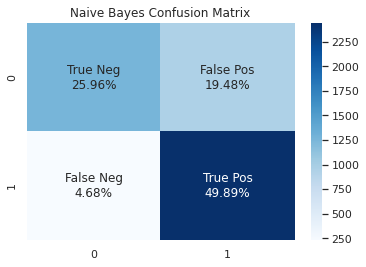

In [ ]:
cf_matrix = confusion_matrix(y_test1, mnb_bow_predict)
print(cf_matrix)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Support Vector Machine


In [ ]:
#SVM
from sklearn import svm
model2 = svm.SVC(probability=True)
model2.fit(x_train1,y_train1)

# testing
y_pred_svm = model2.predict(x_test1)

c=classification_report(y_test1,y_pred_svm)
print(c)

              precision    recall  f1-score   support

           0       0.96      0.58      0.72      2223
           1       0.74      0.98      0.84      2670

    accuracy                           0.80      4893
   macro avg       0.85      0.78      0.78      4893
weighted avg       0.84      0.80      0.79      4893



In [ ]:
pkl_filename = "svmModel.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model2, file)

In [ ]:
alg=svm.SVC()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Model'] = MLA_name
MLA_compare.loc[row_index, 'Accuracy'] = round(model2.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'Precission'] = precision_score(y_test1, y_pred_svm)
MLA_compare.loc[row_index, 'F1 Score']=f1_score(y_test1, y_pred_svm)
row_index+=1
MLA_compare

,MLA Model,Accuracy,Precission,F1 Score
0,LogisticRegression,0.7104,0.653291,0.790292
1,MultinomialNB,0.7584,0.719210,0.805079
2,SVC,0.7975,0.735484,0.841059


[[1280  943]
 [  48 2622]]


<function matplotlib.pyplot.show>

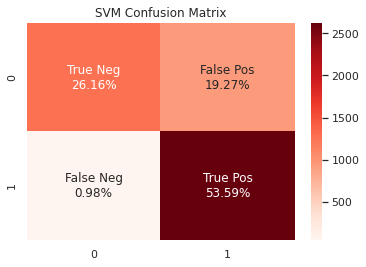

In [ ]:
cf_matrix = confusion_matrix(y_test1, y_pred_svm)
print(cf_matrix)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Decision Trees Classifier

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

#Fit train and test into the model
clf.fit(x_train1, y_train1)

#Predict the result
y_pred_dt = clf.predict(x_test1)

In [ ]:
c=classification_report(y_test1,y_pred_dt)
print(c)

              precision    recall  f1-score   support

           0       1.00      0.51      0.68      2223
           1       0.71      1.00      0.83      2670

    accuracy                           0.78      4893
   macro avg       0.86      0.75      0.75      4893
weighted avg       0.84      0.78      0.76      4893



In [ ]:
 alg=DecisionTreeClassifier()
 MLA_name = alg.__class__.__name__
 MLA_compare.loc[row_index,'MLA Model'] = MLA_name
 MLA_compare.loc[row_index, 'Accuracy'] = round(clf.score(x_test1, y_test1), 4)
 MLA_compare.loc[row_index, 'Precission'] = precision_score(y_test1, y_pred_dt)
 MLA_compare.loc[row_index, 'F1 Score']=f1_score(y_test1, y_pred_dt)
 row_index+=1

[[1133 1090]
 [   0 2670]]


<function matplotlib.pyplot.show>

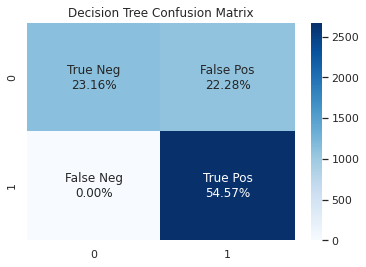

In [ ]:
cf_matrix = confusion_matrix(y_test1, y_pred_dt)
print(cf_matrix)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Random Forest Classifier

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

random_forest.fit(x_train1, y_train1)

y_pred_rf = random_forest.predict(x_test1)

c=classification_report(y_test1,y_pred_rf)
print(c)

              precision    recall  f1-score   support

           0       1.00      0.51      0.68      2223
           1       0.71      1.00      0.83      2670

    accuracy                           0.78      4893
   macro avg       0.86      0.75      0.75      4893
weighted avg       0.84      0.78      0.76      4893



In [ ]:
alg=RandomForestClassifier()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Model'] = MLA_name
MLA_compare.loc[row_index, 'Accuracy'] = round(random_forest.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'Precission'] = precision_score(y_test1, y_pred_rf)
MLA_compare.loc[row_index, 'F1 Score']=f1_score(y_test1, y_pred_rf)
row_index+=1
MLA_compare

,MLA Model,Accuracy,Precission,F1 Score
0,LogisticRegression,0.7104,0.653291,0.790292
1,MultinomialNB,0.7584,0.719210,0.805079
2,SVC,0.7975,0.735484,0.841059
3,DecisionTreeClassifier,0.7772,0.710106,0.830482
4,RandomForestClassifier,0.7772,0.710106,0.830482


[[1133 1090]
 [   0 2670]]


<function matplotlib.pyplot.show>

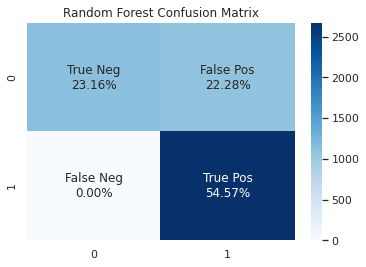

In [ ]:
cf_matrix = confusion_matrix(y_test1, y_pred_rf)
print(cf_matrix)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ML Model Comparision

In [ ]:
#compairing-all-ML Models
MLA_compare.sort_values(by = ['F1 Score'], ascending = False, inplace = True)    
MLA_compare

,MLA Model,Accuracy,Precission,F1 Score
2,SVC,0.7975,0.735484,0.841059
3,DecisionTreeClassifier,0.7772,0.710106,0.830482
4,RandomForestClassifier,0.7772,0.710106,0.830482
1,MultinomialNB,0.7584,0.719210,0.805079
0,LogisticRegression,0.7104,0.653291,0.790292


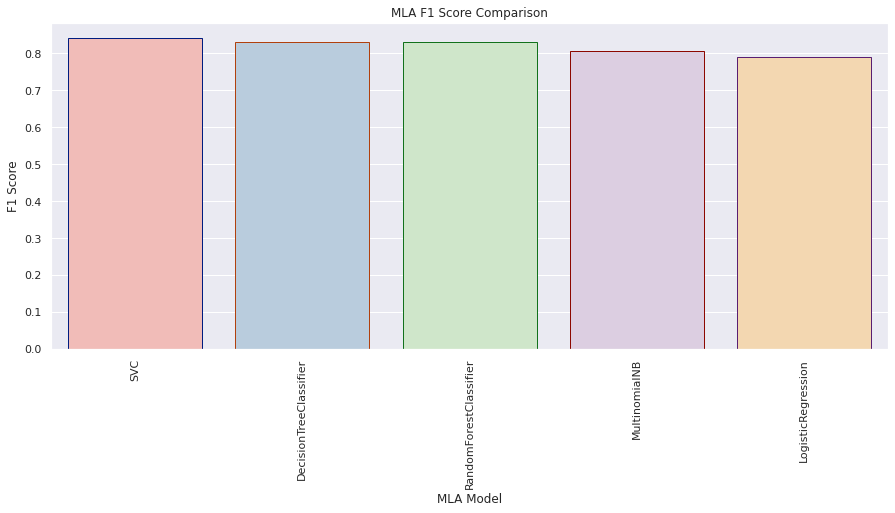

In [ ]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Model", y="F1 Score",data=MLA_compare,palette='Pastel1',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA F1 Score Comparison')
plt.show()